In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re

In [25]:
# Get the burstiness values based on the files present in the directory
results_dir = 'results'
file_pattern = re.compile(r'response_times_burstiness_(\d+).csv')
burstiness_values = []

for filename in os.listdir(results_dir):
    match = file_pattern.match(filename)
    if match:
        burstiness_values.append(int(match.group(1)))

burstiness_values.sort()
burstiness_values

[1, 2, 5, 10, 20]

In [26]:
# Load the data from the CSV files
data_frames = []

for burstiness in burstiness_values:
    file_path = os.path.join(results_dir, f'response_times_burstiness_{burstiness}.csv')
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        data_frames.append(df)

# Combine the data into a single DataFrame
combined_df = pd.concat(data_frames, ignore_index=True)
combined_df

,sourceId,time,responseTime,burstiness
0,2,0.040008,0.000073,1
1,2,0.080070,0.000091,1
2,2,0.120219,0.000106,1
3,2,0.160088,0.000100,1
4,1,0.163750,0.000143,1
...,...,...,...,...
852,2,4.840008,0.004415,20
853,3,4.885277,0.008059,20
854,2,4.905749,0.004475,20
855,2,4.923961,0.004563,20


In [27]:
# Map source IDs to names
source_names = {1: 'Poisson source', 2: 'Constant source', 3: 'Bursty source'}
combined_df['sourceName'] = combined_df['sourceId'].map(source_names)

In [34]:
average_response_times = combined_df.groupby(['sourceId', 'burstiness'])['responseTime'].mean().reset_index()
average_response_times['sourceName'] = average_response_times['sourceId'].map(source_names)

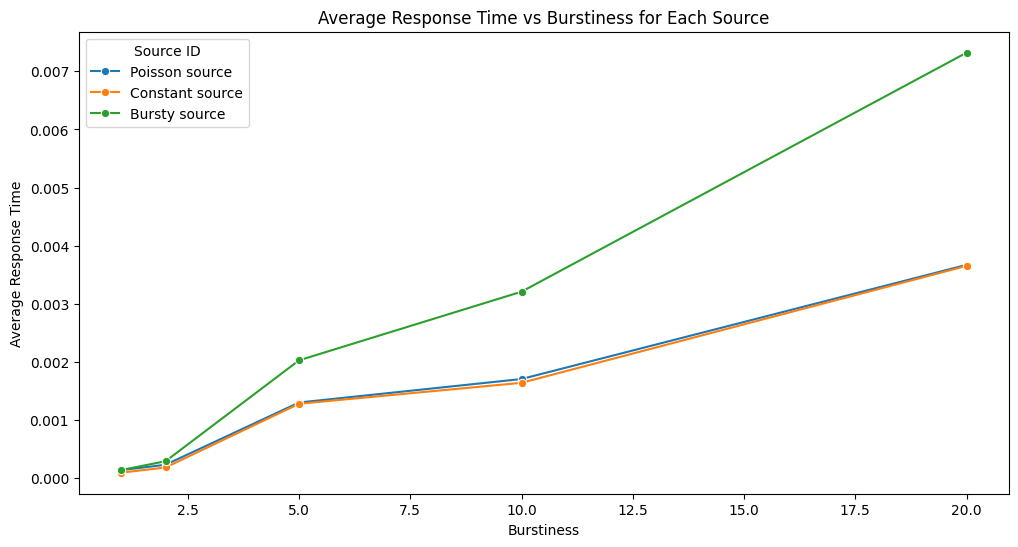

In [35]:
# Plot the average response time for each source with respect to burstiness
plt.figure(figsize=(12, 6))
sns.lineplot(x='burstiness', y='responseTime', hue='sourceName', data=average_response_times, marker='o')
plt.title('Average Response Time vs Burstiness for Each Source')
plt.xlabel('Burstiness')
plt.ylabel('Average Response Time')
plt.legend(title='Source ID')
plt.show()

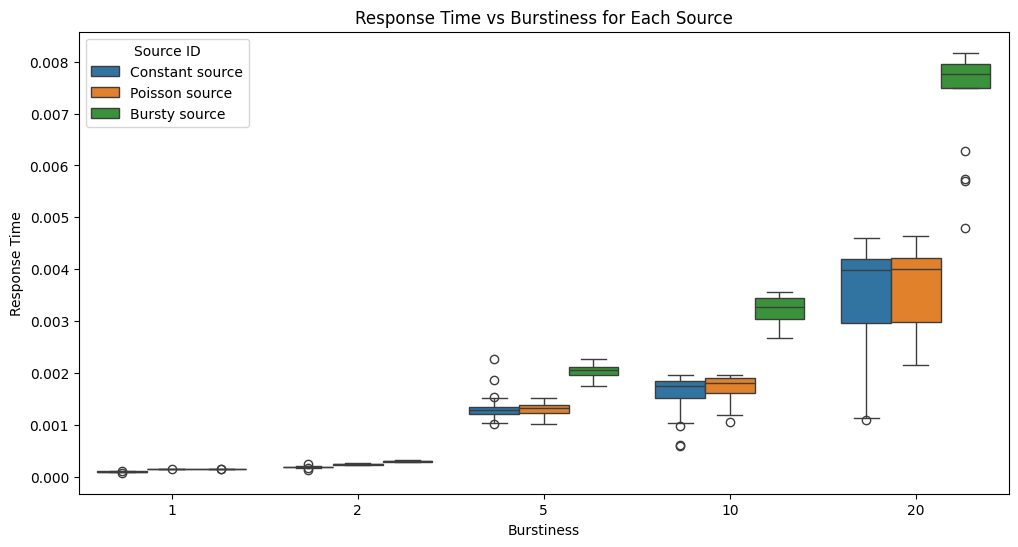

In [ ]:
# Plot separate box plots for each source
plt.figure(figsize=(12, 6))
sns.boxplot(x='burstiness', y='responseTime', hue='sourceName', data=combined_df)
plt.title('Response Time vs Burstiness for Each Source')
plt.xlabel('Burstiness')
plt.ylabel('Response Time')
plt.legend(title='Source ID')
plt.show()

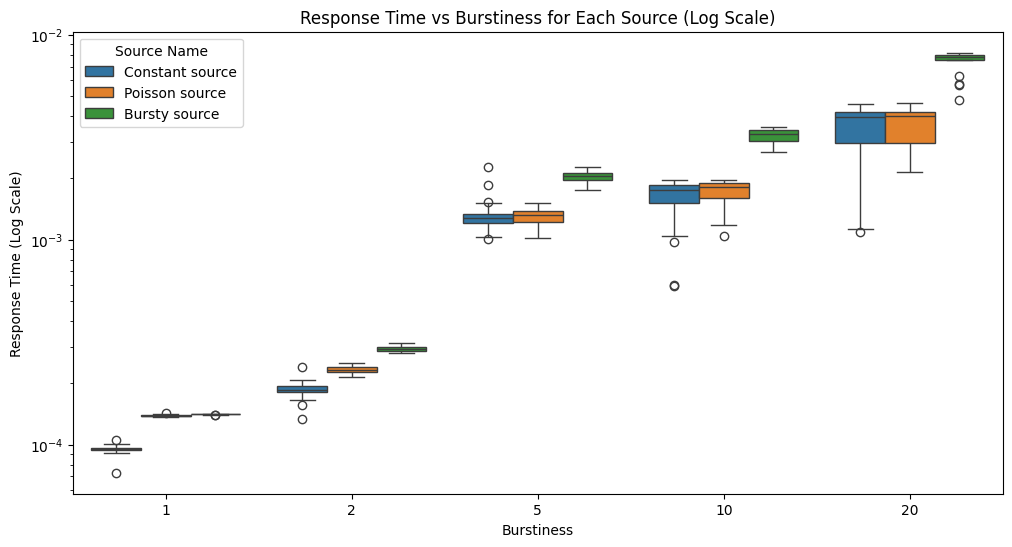

In [ ]:
# Plot separate box plots for each source with a log scale on the y-axis
plt.figure(figsize=(12, 6))
sns.boxplot(x='burstiness', y='responseTime', hue='sourceName', data=combined_df)
plt.yscale('log')
plt.title('Response Time vs Burstiness for Each Source (Log Scale)')
plt.xlabel('Burstiness')
plt.ylabel('Response Time (Log Scale)')
plt.legend(title='Source Name')
plt.show()